# GAN_PI data

In [1]:
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 30.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [11]:
import scipy
import os

In [9]:
!ls ../../gan-pi/resources/data

Buckley_Swc_0_Sor_0_M_2.mat  burgers_shock.mat


In [14]:
path_lib = os.path.dirname(os.getcwd())
path_resources = os.path.join("../../gan-pi", 'resources')
path_data = os.path.join(path_resources, 'data')

filename = 'Buckley_Swc_0_Sor_0_M_2.mat'
path_file = os.path.join(path_data, filename)
data = scipy.io.loadmat(path_file)

In [16]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 't', 'usol', 'x'])

In [17]:
len(data["usol"])

256

# Gradient Notes

In [1]:
import torch

### Grandient example

In [194]:
x1 = torch.ones((3,1,3)).requires_grad_(True)  #
print(x1)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]**0.5,
    torch.cos(x1[:,:,0]),
    x1[:,:,1]**2,
    ],axis=2)

#u1 = torch.matmul(M,x1)


#u1=torch.sin(torch.matmul(torch.rand(2,2).requires_grad_(True),x1))
print(u1)
print(u1.shape)
torch.autograd.grad(
    u1,x1,
            grad_outputs=torch.ones_like(u1).to(u1.device),
            create_graph=True,
            retain_graph=True,
            allow_unused=True
            )

tensor([[[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]], requires_grad=True)
tensor([[[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]]], grad_fn=<StackBackward0>)
torch.Size([3, 1, 4])


(tensor([[[0.1585, 2.5403, 0.0000]],
 
         [[0.1585, 2.5403, 0.0000]],
 
         [[0.1585, 2.5403, 0.0000]]], grad_fn=<AddBackward0>),)

### Jacobian computation

Expressed in pytorch with torch.autograd.grad

$$ \textbf{u} \in \mathbb{R}^n \\ \textbf{x},\textbf{e}_i \in \mathbb{R}^m $$
$$ T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i) = \nabla_{\textbf{x}} \textbf{u}_i  $$
$$ T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i) = \nabla_{\textbf{x}} \textbf{u}_i  $$
$$ T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i+\textbf{e}_j) = \nabla_{\textbf{x}} \textbf{u}_i + \nabla_{\textbf{x}} \textbf{u}_j $$
$$ [T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i)]_{i=1}^n = J_{\textbf{x}}(\textbf{u})$$


In [195]:
unit_vectors=torch.eye(4)
print(u1)
jacobian_rows = [torch.autograd.grad(u1, x1, vec_.unsqueeze(0).unsqueeze(0).tile(u1.shape[0],u1.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
                     for vec_ in unit_vectors]
print(jacobian_rows)
print(torch.stack(jacobian_rows,axis=2))
print(torch.stack(jacobian_rows,axis=2).shape)

torch.autograd.grad(u1, x1, unit_vectors[1].unsqueeze(0).unsqueeze(0).tile(u1.shape[0],u1.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0].shape

tensor([[[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]]], grad_fn=<StackBackward0>)
[tensor([[[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]]], grad_fn=<AddBackward0>), tensor([[[0.5000, 0.5403, 0.0000]],

        [[0.5000, 0.5403, 0.0000]],

        [[0.5000, 0.5403, 0.0000]]], grad_fn=<AddBackward0>), tensor([[[-0.8415,  0.0000,  0.0000]],

        [[-0.8415,  0.0000,  0.0000]],

        [[-0.8415,  0.0000,  0.0000]]], grad_fn=<AddBackward0>), tensor([[[0., 2., 0.]],

        [[0., 2., 0.]],

        [[0., 2., 0.]]], grad_fn=<AddBackward0>)]
tensor([[[[ 0.5000,  0.0000,  0.0000],
          [ 0.5000,  0.5403,  0.0000],
          [-0.8415,  0.0000,  0.0000],
          [ 0.0000,  2.0000,  0.0000]]],


        [[[ 0.5000,  0.0000,  0.0000],
          [ 0.5000,  0.5403,  0.0000],
          [-0.8415,  0.0000,  0.0000],
          [ 0.0000,  2.0000,  0.0000]]],


 

torch.Size([3, 1, 3])

In [73]:
#

def vector_jacobian(u,x):
    unit_vectors=torch.eye(u.shape[-1])
    jacobian_rows = [torch.autograd.grad(u, x, vec_.unsqueeze(0).unsqueeze(0).tile(u.shape[0],u.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
                     for vec_ in unit_vectors]
    return torch.stack(jacobian_rows,axis=2)


def vector_grad(u,x):
    unit_vectors=torch.eye(u.shape[-1])
    jacobian_rows = [torch.autograd.grad(u, x, vec_.unsqueeze(0).unsqueeze(0).tile(u.shape[0],u.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
                     for vec_ in unit_vectors]
    return torch.diagonal(torch.stack(jacobian_rows,axis=2),dim1=-2,dim2=-1)

def x_grad(u,x,i,n):
    """
    gradient of degree wrt x for componen i for u
    input:
    u and x are tensors with vectors object at dimension -1
    [b, n_vectors, vector_dimension]

    output:
    [b, n_vectors, input_vector_dimension]
    """
    I=torch.eye(u.shape[-1])

    u=torch.autograd.grad(u ,x,
            I[i].unsqueeze(0).unsqueeze(0).tile(u.shape[0],u.shape[1],1).to(u.device),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
    if n > 1:
        for i in range(n-1):
            u=vector_grad(u,x)
    return u

In [197]:
print(x_grad(u1,x1,0,1))
udx=x_grad(u1,x1,0,1)


tensor([[[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]]], grad_fn=<AddBackward0>)


In [198]:
print(x1.shape)
x1

torch.Size([3, 1, 3])


tensor([[[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]], requires_grad=True)

In [199]:
torch.sum(x1*udx,axis=-1)

tensor([[0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SumBackward1>)

In [204]:
udx[:,:,:2]

tensor([[[0.5000, 0.0000]],

        [[0.5000, 0.0000]],

        [[0.5000, 0.0000]]], grad_fn=<SliceBackward0>)

# Residuals debug

## NS reesidual

In [259]:
def incompresibble_fluid_loss(up,xt,mu=1,rho=1):
    l=0
    # x-velocity components
    l+=x_grad(up,xt,0,1)[...,2] # dudt
    l+=torch.sum(up[...,:1]*x_grad(up,xt,0,1)[...,:2],axis=-1) # u * grad u
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,0]) #  dpdx
    l-=(mu/rho)*torch.sum(x_grad(up,xt,0,2)[...,:2],axis=-1) # grad**2 u
    # y-velocity components
    l+=x_grad(up,xt,1,1)[...,2] # dvdt
    l+=torch.sum(up[...,1:2]*x_grad(up,xt,0,1)[...,:2],axis=-1) # v * grad v
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,1]) #  dpdy
    l-=(mu/rho)*torch.sum(x_grad(up,xt,1,2)[...,:2],axis=-1) # grad**2 v
    return l

### Debug

In [260]:
x1 = torch.randn((3,1,3)).requires_grad_(True)  #
print(x1)
print(x1.shape)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]**0.5,
    torch.cos(x1[:,:,0]),
    ],axis=2)

print(u1.shape)

tensor([[[-1.5316, -0.0218,  1.3527]],

        [[ 2.0246,  0.5625, -0.8633]],

        [[ 0.5488, -0.9313,  0.3730]]], requires_grad=True)
torch.Size([3, 1, 3])
torch.Size([3, 1, 3])


In [263]:
incompresibble_fluid_loss(u1,x1,1,1)-0
#x_grad(u1,x1,0,1)[...,0]
#print(x1[:,:,:1])
#print(x_grad(u1,x1,0,1)[...,:2])
#x_grad(u1,x1,0,1)[...,2]
#x_grad(u1,x1,0,2)[...,:2]

tensor([[   nan],
        [0.9955],
        [0.3642]], grad_fn=<SubBackward0>)

## 2 phase 2 dimensional Darcy flow

$$\frac{\partial}{\partial t} \left( \phi \frac{S_w}{B_w} \right)+ \nabla \cdot \left( \frac{1}{B_w} \mathbf{u}_w \right)= 0 \\
\frac{\partial}{\partial t} \left( \phi \frac{S_o}{B_o} \right)
+ \nabla \cdot \left( \frac{1}{B_o} \mathbf{u}_o \right)
= 0 \\
\mathbf{u}_\alpha = -k \frac{k_{r\alpha}}{\mu_\alpha} \left( \nabla P_\alpha - \rho_\alpha g \nabla z \right)$$

$$
\frac{\partial}{\partial t} \left( \phi \frac{S_w}{B_w} \right)+ \nabla \cdot \left( \frac{1}{B_w} \mathbf{u}_w \right)= 0 \\
\frac{\partial}{\partial t} \left( \phi \frac{S_o}{B_o} \right)
+ \nabla \cdot \left( \frac{1}{B_o} \mathbf{u}_o \right)
= 0 \\
\mathbf{u}_\alpha = -k \frac{k_{r\alpha}}{\mu_\alpha} \left( \nabla P_\alpha - \rho_\alpha g \nabla z \right)
$$

$$
\frac{1}{\mu_o} \nabla \cdot (K_o(S) \nabla \Phi_o) = - \phi \frac{\partial S}{\partial p_c} \left ( \frac{\partial \Phi_o}{\partial t} -\frac{\partial \Phi_w}{\partial t} \right ) \\
\frac{1}{\mu_w} \nabla \cdot (K_w(S) \nabla \Phi_w) = \phi \frac{\partial S}{\partial p_c} \left ( \frac{\partial \Phi_o}{\partial t} -\frac{\partial \Phi_w}{\partial t} \right )
$$

$$
\frac{1}{\mu_o} \nabla \cdot (K_o(S) \nabla \Phi_o) = - \phi \left ( \frac{\partial S_o}{\partial t} \right ) \\
\frac{1}{\mu_w} \nabla \cdot (K_w(S) \nabla \Phi_w) = - \phi \left ( \frac{\partial S_w}{\partial t} \right )
$$

$$p_c=f(S_w)$$

$$
p_t=p_o+p_w \\
p_c=p_o-p_w \\

p_o=\frac{p_t+p_c}{2} =\frac{p_t+f(S_w)}{2} \\
$$
$$
p_w=\frac{p_t-p_c}{2}=\frac{p_t-f(S_w)}{2}
$$

### Brooks-Corey Model

#### **1. Effective Saturation**  
$$
S_e = \frac{S_w - S_{wc}}{1 - S_{wc} - S_{or}} 
$$ 
- **Variables**:  
  - $(S_w)$ : Water saturation $[0, 1]$
  - $(S_{wc})$: Irreducible water saturation $[0 \leq S_{wc} < 1]$
  - $(S_{or})$: Residual oil saturation $[0 \leq S_{or} < 1]$
- **Domain**:  
  $S_e \in [0, 1]$ when $S_w \in [S_{wc}, 1 - S_{or}]$

---

#### **2. Capillary Pressure**  
$$
P_c(S_e) = 
\begin{cases} 
P_{\text{entry}} \cdot S_e^{-1/\lambda} & S_e > 0 \\
\infty & S_e = 0 
\end{cases}
$$  
- **Parameters**:  
  - $P_{\text{entry}} > 0$: Entry pressure  
  - $\lambda > 0$: Pore-size distribution index  
- **Behavior**:  
  - $\lim_{S_e \to 0^+} P_c = \infty$  
  - $P_c(S_e=1) = P_{\text{entry}}$  

---

#### **3. Relative Permeability**  
**Wetting phase (e.g., water)**:  
$$
k_{rw}(S_e) = k_{rw}^0 \cdot S_e^{\frac{2 + 3\lambda}{\lambda}}
$$  
**Non-wetting phase (e.g., oil)**:  
$$
k_{ro}(S_e) = k_{ro}^0 \cdot (1 - S_e)^2 \cdot \left(1 - S_e^{\frac{2 + \lambda}{\lambda}}\right)
$$  
- **Parameters**:  
  - $k_{rw}^0 \in (0, 1]$: Endpoint rel. perm. for water  
  - $k_{ro}^0 \in (0, 1]$: Endpoint rel. perm. for oil  
- **Constraints**:  
  - $k_{rw}(S_e=0) = 0$, $\quad k_{rw}(S_e=1) = k_{rw}^0$  
  - $k_{ro}(S_e=0) = k_{ro}^0$, $\quad k_{ro}(S_e=1) = 0$  

---

#### **4. Key Assumptions**  
1. Models **drainage** (non-wetting phase invasion)  
2. $\lambda$ quantifies pore uniformity:  
   - High $\lambda$: Uniform pores (well-sorted sand)  
   - Low $\lambda$: Heterogeneous pores (poorly sorted sand/clay)  
3. Irreducible saturations $S_{wc}$, $S_{or}$ are static  

---

#### **5. Hysteresis**  
- Standard model describes **drainage** only  
- **Imbibition** requires scanning curves or modified parameters  

---

#### **6. Parameter Ranges**  
| Parameter       | Typical Range          | Dependence               |  
|-----------------|------------------------|--------------------------|  
| $S_{wc}$      | 0.05–0.45             | Rock type, wettability   |  
| $S_{or}$      | 0.20–0.45             | Rock type, fluid properties |  
| $\lambda$     | 0.5–5.0               | Pore-size distribution   |  
| $P_{\text{entry}}$ | 0.1–10 kPa (sand)<br>10–100 kPa (clay) | Interfacial tension,

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy

SWC=sympy.symbols("S_{wc}")
SOR=sympy.symbols("S_{or}")
Sw=sympy.symbols("S_w")
lam=sympy.symbols("\lambda")
Pi=sympy.symbols("P_i")
K_rw0=sympy.symbols("k_{rw0}")
K_ro0=sympy.symbols("k_{ro0}")

Pc_=sympy.symbols("P_c")

Sc=(Sw-SWC)/(1-SWC-SOR)
Pc=Pi*Sc**(-1/lam)

K_rw=K_rw0*Sc**((2+3*lam)/(lam))
K_ro=K_ro0*((1-Sc)**2)*(1-Sc**((2+lam)/(lam)))
Pc
sympy.Eq(Pc,Pc_)

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Eq(P_i/((S_w - S_{wc})/(-S_{or} - S_{wc} + 1))**(1/\lambda), P_c)

In [ ]:
Sw_Pc=(1-SWC-SOR)*((Pc_/Pi)**(-1*lam))+SWC
sympy.diff(Sw_Pc,Pc_)



-\lambda*(-S_{or} - S_{wc} + 1)/(P_c*(P_c/P_i)**\lambda)

: 

<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in power
  return P_i*((-Dummy_74 + S_w)/(-Dummy_74 - Dummy_75 + 1))**(-1/Dummy_73)


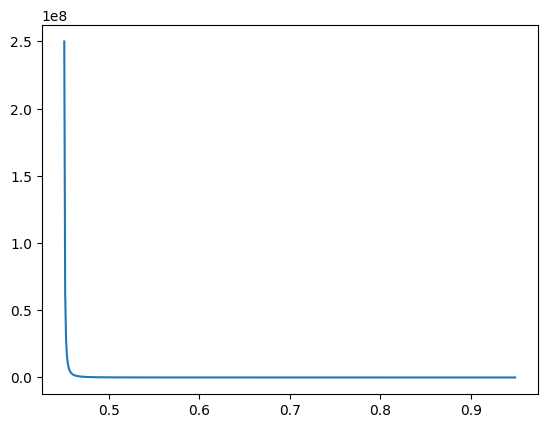

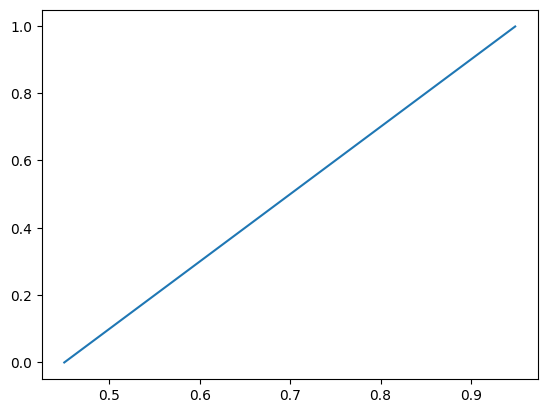

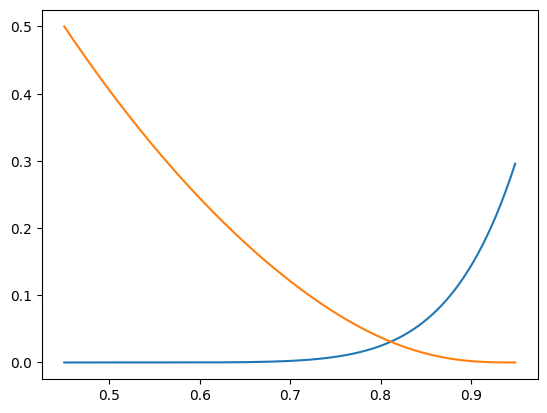

<lambdifygenerated-17>:2: RuntimeWarning: invalid value encountered in divide
  return Dummy_86*((-Dummy_88 + S_w)/(-Dummy_88 - Dummy_89 + 1))**((3*Dummy_87 + 2)/Dummy_87)*(3*Dummy_87 + 2)/(Dummy_87*(-Dummy_88 + S_w))
<lambdifygenerated-18>:2: RuntimeWarning: invalid value encountered in divide
  return -2*Dummy_90*(1 - ((-Dummy_92 + S_w)/(-Dummy_92 - Dummy_93 + 1))**((Dummy_91 + 2)/Dummy_91))*(-(-Dummy_92 + S_w)/(-Dummy_92 - Dummy_93 + 1) + 1)/(-Dummy_92 - Dummy_93 + 1) - Dummy_90*((-Dummy_92 + S_w)/(-Dummy_92 - Dummy_93 + 1))**((Dummy_91 + 2)/Dummy_91)*(Dummy_91 + 2)*(-(-Dummy_92 + S_w)/(-Dummy_92 - Dummy_93 + 1) + 1)**2/(Dummy_91*(-Dummy_92 + S_w))


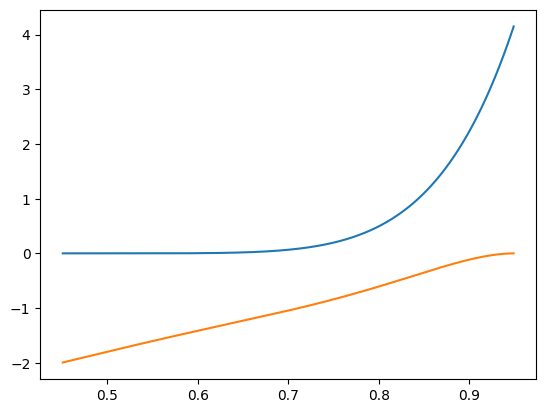

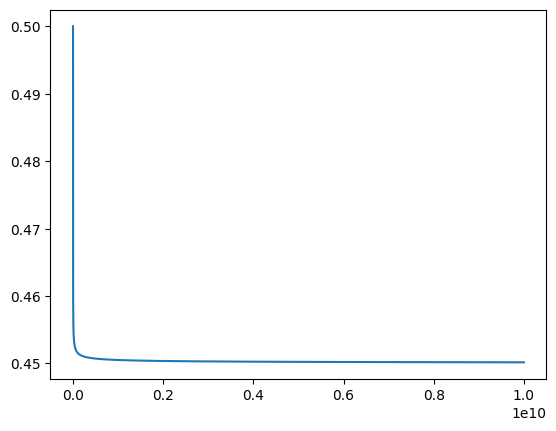

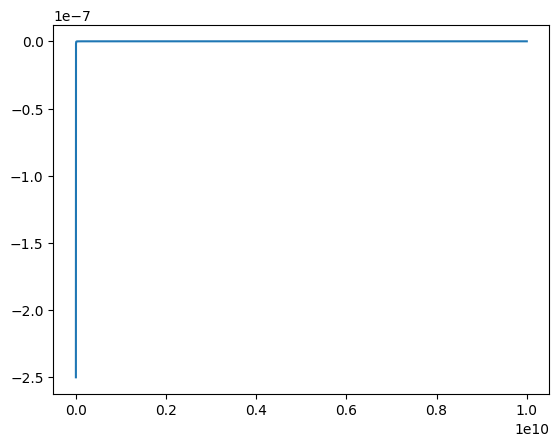

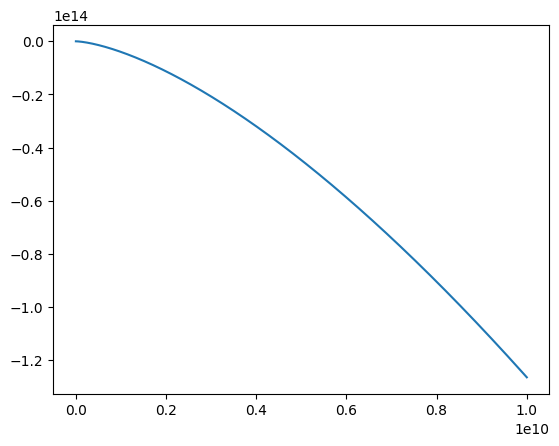

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import sympy
from copy import deepcopy
Sw_args={
    "SOR":0.05,
    "SWC":0.45
}
Pc_args=Sw_args.copy()
Pc_args.update({
    "lam":0.5,
    "Pi":1e3
    })

SWC=sympy.symbols("S_{wc}")
SOR=sympy.symbols("S_{or}")
Sw=sympy.symbols("S_w")
lam=sympy.symbols("\lambda")
Pi=sympy.symbols("P_i")
K_rw0=sympy.symbols("k_{rw0}")
K_ro0=sympy.symbols("k_{ro0}")

Sc=(Sw-SWC)/(1-SWC-SOR)
Pc=Pi*Sc**(-1/lam)

Sw_Pc=(1-SWC-SOR)*((Pc_/Pi)**(-1*lam))+SWC
dScdPc=sympy.diff(Sw_Pc,Pc_)


K_rw=K_rw0*Sc**((2+3*lam)/(lam))
K_ro=K_ro0*((1-Sc)**2)*(1-Sc**((2+lam)/(lam)))

#Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,0.05,0.45,0.5,1e5)
Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,*tuple(Pc_args.values()))
Se_f=lambda sw: sympy.lambdify((Sw,SOR,SWC),Sc)(sw,*tuple(Sw_args.values()))
K_rw_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_rw0),K_rw)(sw,*tuple(Pc_args.values()),0.3)
K_ro_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_ro0),K_ro)(sw,*tuple(Pc_args.values()),0.5)

sympy.diff(K_rw,Sw)
sympy.diff(K_ro,Sw)
dK_rw_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_rw0),sympy.diff(K_rw,Sw))(sw,*tuple(Pc_args.values()),0.3)
dK_ro_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_ro0),sympy.diff(K_ro,Sw))(sw,*tuple(Pc_args.values()),0.5)

Sw_Pc_f=lambda sw: sympy.lambdify((Pc_,SOR,SWC,lam,Pi),Sw_Pc)(sw,*tuple(Pc_args.values()))
dScdPc_f=lambda sw: sympy.lambdify((Pc_,SOR,SWC,lam,Pi),dScdPc)(sw,*tuple(Pc_args.values()))

Sw_points=np.arange(0.45,1-0.05,0.001) # SWR,1-SOR
Pc_points=np.arange(1e5,1e10,10.0) # SWR,1-SOR
plt.plot(Sw_points,Pc_f(Sw_points))
plt.show()
plt.plot(Sw_points,Se_f(Sw_points))
plt.show()
plt.plot(Sw_points,K_rw_f(Sw_points))
plt.plot(Sw_points,K_ro_f(Sw_points))
plt.show()
plt.plot(Sw_points,dK_rw_f(Sw_points))
plt.plot(Sw_points,dK_ro_f(Sw_points))
plt.show()

plt.plot(Pc_points,Sw_Pc_f(Pc_points))
plt.show()

plt.plot(Pc_points,dScdPc_f(Pc_points))
plt.show()

plt.plot(Pc_points,1/(dScdPc_f(Pc_points)))
plt.show()

In [9]:
K_rw

k_{rw0}*((S_w - S_{wc})/(-S_{or} - S_{wc} + 1))**((3*\lambda + 2)/\lambda)

In [10]:
#Pc_points[0]
print(1/(dScdPc_f(Pc_points[0])))
print(1/(dScdPc_f(Pc_points[-1])))

-399999.99999999994
-12649110621699.85


In [69]:
import torch
def transform_sw_pt2pa(Sw,pt):
    pc=Pc_f(Sw)
    p_o=(pt+pc)/2
    p_w=(pt-pc)/2
    return p_o,p_w

$$
\frac{1}{\mu_o} \nabla \cdot (K_o(S) \nabla \Phi_o) = - \phi \left ( \frac{\partial S_o}{\partial t} \right ) \\
\frac{1}{\mu_w} \nabla \cdot (K_w(S) \nabla \Phi_w) = - \phi \left ( \frac{\partial S_w}{\partial t} \right )
$$

In [70]:
#OsWsPoPwBo
def two_phase_darcy_flow(Uv,xtk,muw=0.32,muo=1.295,porosity=0.2):
    l=0
    # grad n of U-ith comp wrt to x, indexing to choose x-ith derivative
    # x-velocity components
    Ko=torch.tensor([
        [xtk[3],0],[0,xtk[4]]
        ])
    Kw=torch.tensor([
        [xtk[3],0],[0,xtk[4]]
        ])
    l+=vector_grad( # oil pressure gradient
            torch.tensordot(
            x_grad(Uv,xtk,2,1)[...,:2],
            Ko,dims=([-1],[1])),xtk).sum(-1)/muo
    l+=porosity * x_grad(Uv,xtk,0,1)[...,2] # Oil saturatin change
    l+=vector_grad( # oil pressure gradient
            torch.tensordot(
            x_grad(Uv,xtk,3,1)[...,:2],
            Ko,dims=([-1],[1])),xtk).sum(-1)/muw
    l+=porosity * x_grad(Uv,xtk,1,1)[...,2] # Oil saturatin change
    
    return l

In [152]:
#from 

x1 = torch.abs(torch.randn((3,2,5))).requires_grad_(True)  # batch p u
print(x1)
print(x1.shape)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    x1[:,:,1]*0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]*0.5,
    torch.cos(x1[:,:,3]),
    torch.cos(x1[:,:,4]),
    ],axis=2)

Ko=torch.tensor([
        [2.,0],[0,2.]
        ])

print(x_grad(u1,x1,2,1)[...,:2])
vector_grad(
    torch.tensordot(
    x_grad(u1,x1,2,1)[...,:2],
    Ko,dims=([-1],[1])
),x1).sum(-1)

#torch.matmul(
#    Ko,
#    x_grad(u1,x1,2,1)[...,:2]
#)

tensor([[[0.7434, 0.6072, 1.2645, 0.5815, 0.0273],
         [0.3705, 0.9131, 1.8013, 0.5695, 0.3152]],

        [[0.6184, 0.2705, 1.0670, 1.4077, 0.7457],
         [0.4989, 0.0922, 0.0203, 1.0605, 0.4518]],

        [[0.5878, 0.4296, 0.0558, 0.8286, 1.6997],
         [0.4021, 0.7854, 0.5171, 1.0152, 1.4765]]], requires_grad=True)
torch.Size([3, 2, 5])
tensor([[[0.5000, 0.8212],
         [0.5000, 0.6113]],

        [[0.5000, 0.9636],
         [0.5000, 0.9958]],

        [[0.5000, 0.9091],
         [0.5000, 0.7071]]], grad_fn=<SliceBackward0>)


torch.Size([3, 2])

In [ ]:
x1 = torch.abs(torch.randn((3,2,5))).requires_grad_(True)  # batch p u
print(x1)
print(x1.shape)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    x1[:,:,1]*0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]*0.5,
    torch.cos(x1[:,:,3]),
    torch.cos(x1[:,:,4]),
    ],axis=2)

Ko=torch.tensor([
        [2.,0],[0,2.]
        ])

print(x_grad(u1,x1,2,1)[...,:2])
vector_grad(
    torch.tensordot(
    x_grad(u1,x1,2,1)[...,:2],
    Ko,dims=([-1],[1])
),x1).sum(-1)

In [197]:
Ko=torch.stack(
    [torch.stack([x1[...,2],torch.zeros_like(x1[...,2])],axis=2),
     torch.stack([torch.zeros_like(x1[...,2]),x1[...,2]],axis=2)],axis=3)


Ko=torch.stack(
    [torch.stack([torch.ones_like(x1[...,2]),torch.zeros_like(x1[...,2])],axis=2),
     torch.stack([torch.zeros_like(x1[...,2]),torch.ones_like(x1[...,2])],axis=2)],axis=3)

In [198]:
Ko.shape

torch.Size([3, 2, 2, 2])

In [220]:
x_grad(u1,x1,2,1)[...,:2].unsqueeze(-2).shape

torch.Size([3, 2, 1, 2])

In [223]:
torch.tensordot(
    Ko,
    x_grad(u1,x1,2,1)[...,:2].unsqueeze(-2),
    dims=([-2,-1],[-2,-1])
)

tensor([[[[1.3212, 1.1113],
          [1.4636, 1.4958],
          [1.4091, 1.2071]],

         [[1.3212, 1.1113],
          [1.4636, 1.4958],
          [1.4091, 1.2071]]],


        [[[1.3212, 1.1113],
          [1.4636, 1.4958],
          [1.4091, 1.2071]],

         [[1.3212, 1.1113],
          [1.4636, 1.4958],
          [1.4091, 1.2071]]],


        [[[1.3212, 1.1113],
          [1.4636, 1.4958],
          [1.4091, 1.2071]],

         [[1.3212, 1.1113],
          [1.4636, 1.4958],
          [1.4091, 1.2071]]]], grad_fn=<ViewBackward0>)

In [174]:
torch.matmul(
    Ko,
    x_grad(u1,x1,2,1)[...,:2]
).shape

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

# DATALOADER DEBUG

In [1]:
import sys
import os

sys.path.append("..")


In [2]:
from data_utils.dataloaders import simulationbasedh5Dataset

data=simulationbasedh5Dataset(
    path="../PhysicsSimulationDeepLearning/Data",
    training_mode="point_prediction",
    prediction_horizon=None,
    sequence_dim=None,
    simulation_time_step=1,
    start_time=1,
    position_fields=["GridCentroidX","GridCentroidY"],
    files_extension="h5")

data[0][0].T

,X,Y,Z,FR,Porosity,PermeabilityK,NetPay,PermeabilityJ,GridCentroidY,GridTop,...,PermeabilityI,NettoGrossRatio,t,OS,OV,OVF,P,SGR,WS,WV
0,1.0,1.0,1.0,0.0,0.2,100.0,25.0,100.0,-50.0,2500.0,...,100.0,1.0,1.0,0.700000,1.295,0.967360,248.840,1.0,0.300000,0.32
1,1.0,2.0,1.0,0.0,0.2,100.0,25.0,100.0,-150.0,2500.0,...,100.0,1.0,1.0,0.700000,1.295,0.967360,248.840,1.0,0.300000,0.32
2,1.0,3.0,1.0,0.0,0.2,100.0,25.0,100.0,-250.0,2500.0,...,100.0,1.0,1.0,0.700000,1.295,0.967360,248.840,1.0,0.300000,0.32
3,1.0,4.0,1.0,0.0,0.2,100.0,25.0,100.0,-350.0,2500.0,...,100.0,1.0,1.0,0.700000,1.295,0.967360,248.840,1.0,0.300000,0.32
4,1.0,5.0,1.0,0.0,0.2,100.0,25.0,100.0,-450.0,2500.0,...,100.0,1.0,1.0,0.700000,1.295,0.967360,248.840,1.0,0.300000,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863995,60.0,56.0,1.0,0.0,0.2,100.0,25.0,100.0,-5550.0,2500.0,...,100.0,1.0,240.0,0.474551,1.295,0.967726,246.060,1.0,0.525449,0.32
863996,60.0,57.0,1.0,0.0,0.2,100.0,25.0,100.0,-5650.0,2500.0,...,100.0,1.0,240.0,0.475113,1.295,0.969137,235.345,1.0,0.524887,0.32
863997,60.0,58.0,1.0,0.0,0.2,100.0,25.0,100.0,-5750.0,2500.0,...,100.0,1.0,240.0,0.476337,1.295,0.970766,222.972,1.0,0.523663,0.32
863998,60.0,59.0,1.0,0.0,0.2,100.0,25.0,100.0,-5850.0,2500.0,...,100.0,1.0,240.0,0.477238,1.295,0.972369,210.800,1.0,0.522762,0.32


In [2]:
from data_utils.dataloaders import pointbasedh5Dataset

data=pointbasedh5Dataset(
    path="../PhysicsSimulationDeepLearning/Data",
    training_mode="point_prediction",
    prediction_horizon=None,
    sequence_dim=None,
    simulation_time_step=1,
    start_time=1,
    position_fields=["GridCentroidX","GridCentroidY"],
    files_extension="h5")



In [6]:
len(data)
#data.data
#list(map(lambda d: len(data.dataFrame2Tensor(data.h52dataFrames(d))[0]),data.data))

4320000

In [3]:
data[0]

X                        1.00000
Y                        1.00000
Z                        1.00000
FR                       0.00000
Porosity                 0.20000
PermeabilityK          100.00000
NetPay                  25.00000
PermeabilityJ          100.00000
GridCentroidY          -50.00000
GridTop               2500.00000
GridThickness           25.00000
GrossBlockVolume    250000.00000
GridCentroidX           50.00000
PermeabilityI          100.00000
NettoGrossRatio          1.00000
t                        1.00000
OS                       0.70000
OV                       1.29500
OVF                      0.96736
P                      248.84000
SGR                      1.00000
WS                       0.30000
WV                       0.32000
Name: 0, dtype: float64

In [4]:
from data_utils.dataloaders import pointbasedPandasDataset

data=pointbasedPandasDataset(
    path="../PhysicsSimulationDeepLearning/Data",
    training_mode="point_prediction",
    prediction_horizon=None,
    sequence_dim=None,
    simulation_time_step=1,
    start_time=1,
    position_fields=["GridCentroidX","GridCentroidY"],
    )

In [5]:
len(data)
#import pandas as pd
#len(pd.read_csv(data.data[2]))
#list(map(lambda d: len(pd.read_csv(d)),data.data))


32039348

In [6]:
data[0]

[       0     4225     8450   283075   724075   998700 10259700 10320200
 10324425 19585425 19589650 19593875 19598100 19602325 19606550 28867550
 28871775 28876000 28877089 29318089 29322314 29763314 31351634 31355859
 31356948 31361173 32026673 32030898 32035123 32039348]
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


Unnamed: 0    0.000000e+00
u             1.504633e-36
x             0.000000e+00
y             0.000000e+00
z             0.000000e+00
t                      NaN
Name: 0, dtype: float64